In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

#q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_practice_juntoaug17
#WHERE 1=1'''
#df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard')
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)
df1 = pd.read_csv('chem_by_subpara_by_practice_juntoaug17',dtype={'subpara': object}) # read from local csv as memory issues with pd.io

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)


In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all practices
b = df1[["pct","practice"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","practice","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","practice","subpara","denom"]].groupby(["subpara","pct","practice"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct","practice"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct","practice"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
#data2 = data2.set_index(['pct','chemical'])
data2.head(3)

,pct,practice,subpara,denom_subpara,chemical,num,denom,ratio
0,04V,C82041,0307000,44.0,0307000J0,44.0,44.0,1.0
1,04V,C82041,0307000,44.0,0307000K0,0.0,0.0,0.0
2,04V,C82041,0307000,44.0,0307000Q0,0.0,0.0,0.0


# National
- take ratios of chemical/subparagraph from above
- calculate the *national* mean ratio and standard deviation for each chemical

In [3]:
df2_nat = data2[["chemical", "ratio"]].groupby(["chemical"]).describe()
df2_nat.columns = df2_nat.columns.droplevel()
df2_nat.head(3)

,count,mean,std,min,25%,50%,75%,max
chemical,,,,,,,,
0101010C0,5624.0,0.035670,0.148797,0.0,0.0,0.000,0.0,1.0
0101010F0,5624.0,0.003186,0.044284,0.0,0.0,0.000,0.0,1.0
0101010G0,5624.0,0.414975,0.394887,0.0,0.0,0.375,0.8,1.0


- calculate the number of standard deviations each practice is from the national mean, for each chemical

In [4]:
output_nat = data2.merge(df2_nat[['mean','std']],how='left', left_on=['chemical'],right_index=True)

output_nat['stds_from_mean'] = (output_nat['ratio'] - output_nat['mean']) / output_nat['std']
output_nat = output_nat.dropna().sort_values('stds_from_mean',ascending =False)
output_nat = output_nat.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output_nat = output_nat.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output_nat = output_nat.drop(['subpara','denom_subpara','chemical'],axis=1)
output_nat = output_nat.set_index(['practice','chemical_code'])
#output_nat.head(3)

### More than usual

In [5]:
output_nat.loc[output_nat.denom>200].sort_values('stds_from_mean',
                                                 ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
F81074,020400010,06Q,1.0,970.0,0.001031,1.406066e-07,0.000012,85.615420,Pindolol With Diuretic,Beta-Adrenoceptor Blocking Drugs,0204000
L81622,0212000AG,11H,2.0,659.0,0.003035,4.139819e-07,0.000035,85.609580,Policosanol,Lipid-Regulating Drugs,0212000
M85025,021200000,04X,1.0,1384.0,0.000723,9.856000e-08,0.000008,85.609580,Other Lipid-Regulating Preps,Lipid-Regulating Drugs,0212000
F81027,0212000V0,07H,1.0,6452.0,0.000155,2.114182e-08,0.000002,85.609580,Omega-3 Marine Triglycerides,Lipid-Regulating Drugs,0212000
M82043,0403010C0,05N,1.0,665.0,0.001504,2.051793e-07,0.000018,85.597898,Amoxapine,Tricyclic & Related Antidepressant Drugs,0403010


- filter out ones with small ratio

In [6]:
output_nat.loc[(output_nat.denom>200)
               &(output_nat['mean']>0.01)].sort_values('stds_from_mean',
                                                       ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
M85670,0103050R0,13P,222.0,347.0,0.639769,0.020097,0.027576,22.471677,Pantoprazole,Proton Pump Inhibitors,0103050
L84615,0205052V0,11M,425.0,701.0,0.606277,0.021632,0.029649,19.718936,Valsartan,Angiotensin-II Receptor Antagonists,0205052
C83022,0205052Q0,99D,1537.0,2306.0,0.666522,0.017529,0.034551,18.783890,Telmisartan,Angiotensin-II Receptor Antagonists,0205052
F81751,0205052V0,06Q,308.0,547.0,0.563071,0.021632,0.029649,18.261701,Valsartan,Angiotensin-II Receptor Antagonists,0205052
M85139,0103050R0,13P,579.0,1137.0,0.509235,0.020097,0.027576,17.737998,Pantoprazole,Proton Pump Inhibitors,0103050


### Less than usual

In [7]:
output_nat.loc[output_nat.denom>200].sort_values('stds_from_mean',
                                                 ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
P81100,0501012G0,01A,315.0,316.0,0.996835,1.000000,0.000037,-85.580372,Flucloxacillin Sodium,Penicillinase-Resistant Penicillins,0501012
P81016,0906027G0,00R,118.0,330.0,0.357576,0.997524,0.024251,-26.389000,Vitamin B Compound,Vitamin B Compound,0906027
L81044,0906026M0,11T,561.0,605.0,0.927273,0.999868,0.003746,-19.377469,Thiamine Hydrochloride,Thiamine Hydrochloride (B1),0906026
P84047,0602010V0,14L,244.0,259.0,0.942085,0.997819,0.003942,-14.140383,Levothyroxine Sodium,Thyroid Hormones,0602010
K84016,0602010V0,10Q,429.0,451.0,0.951220,0.997819,0.003942,-11.822848,Levothyroxine Sodium,Thyroid Hormones,0602010


- filter out ones with small ratio

In [8]:
output_nat.loc[(output_nat.denom>200)
               &(output_nat['mean']<0.99)].sort_values('stds_from_mean',
                                                       ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
J81078,0205040D0,11J,126.0,236.0,0.533898,0.978408,0.041976,-10.589725,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040
L82039,0205040D0,11N,130.0,233.0,0.557940,0.978408,0.041976,-10.016972,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040
C83631,0906040G0,99D,235.0,365.0,0.643836,0.955130,0.031335,-9.934361,Colecalciferol,Vitamin D,0906040
B81095,0601060D0,03F,169.0,258.0,0.655039,0.962421,0.031150,-9.867778,Glucose Blood Testing Reagents,Diabetic Diagnostic & Monitoring Agents,0601060
M83121,0205040D0,05G,165.0,289.0,0.570934,0.978408,0.041976,-9.707403,Doxazosin Mesilate,Alpha-Adrenoceptor Blocking Drugs,0205040


## 99P
### More than usual

In [9]:
output_nat.loc[(output_nat.pct=='99P')
               &(output_nat.denom>200)].sort_values('stds_from_mean',
                                                    ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83643,0212000AI,99P,1.0,667.0,0.001499,0.000002,0.000053,28.199412,Alirocumab,Lipid-Regulating Drugs,0212000
L83628,0407010AA,99P,1.0,909.0,0.001100,0.000001,0.000041,26.591893,Aspirin & Caffeine,Non-Opioid Analgesics And Compound Prep,0407010
L83012,0205051Y0,99P,146.0,789.0,0.185044,0.001178,0.007182,25.601196,Perindopril Arginine,Angiotensin-Converting Enzyme Inhibitors,0205051
L83016,0901011Y0,99P,42.0,771.0,0.054475,0.000139,0.002582,21.042445,Ferric Maltol,Oral Iron,0901011
L83044,0204000AC,99P,2.0,1567.0,0.001276,0.000003,0.000062,20.632495,Bisoprolol Fumarate/Aspirin,Beta-Adrenoceptor Blocking Drugs,0204000


- filter out ones with small ratio

In [10]:
output_nat.loc[(output_nat.pct=='99P')
               &(output_nat.denom>200)
               &(output_nat['mean']>0.01)].sort_values('stds_from_mean',
                                                       ascending =False).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83012,0205052Q0,99P,293.0,478.0,0.612971,0.017529,0.034551,17.233945,Telmisartan,Angiotensin-II Receptor Antagonists,0205052
L83643,0206020R0,99P,136.0,281.0,0.483986,0.049498,0.043056,10.091244,Nifedipine,Calcium-Channel Blockers,0206020
L83663,0403030P0,99P,164.0,561.0,0.292335,0.039735,0.025490,9.909595,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,0403030
L83134,0206020L0,99P,711.0,1087.0,0.654094,0.051798,0.074624,8.071075,Lercanidipine Hydrochloride,Calcium-Channel Blockers,0206020
L83023,0205052Q0,99P,186.0,653.0,0.284839,0.017529,0.034551,7.736790,Telmisartan,Angiotensin-II Receptor Antagonists,0205052


### Less than usual

In [11]:
output_nat.loc[(output_nat.pct=='99P')
               &(output_nat.denom>200)].sort_values('stds_from_mean'
                                                    ,ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83102,0602010V0,99P,1150.0,1179.0,0.975403,0.997819,0.003942,-5.687275,Levothyroxine Sodium,Thyroid Hormones,0602010
L83112,0704010U0,99P,131.0,262.0,0.500000,0.884759,0.084858,-4.534128,Tamsulosin Hydrochloride,Drugs For Urinary Retention,0704010
L83673,0403010B0,99P,123.0,290.0,0.424138,0.805378,0.090115,-4.230574,Amitriptyline Hydrochloride,Tricyclic & Related Antidepressant Drugs,0403010
L83134,0206020A0,99P,312.0,1087.0,0.287029,0.708416,0.130218,-3.236014,Amlodipine,Calcium-Channel Blockers,0206020
L83136,0501013B0,99P,115.0,213.0,0.539906,0.822748,0.089521,-3.159482,Amoxicillin,Broad-Spectrum Penicillins,0501013


- filter out ones with small ratio

In [12]:
output_nat.loc[(output_nat.pct=='99P')
               &(output_nat.denom>200)
               &(output_nat['mean']<0.99)].sort_values('stds_from_mean',
                                                       ascending =True).head(5)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83112,0704010U0,99P,131.0,262.0,0.500000,0.884759,0.084858,-4.534128,Tamsulosin Hydrochloride,Drugs For Urinary Retention,0704010
L83673,0403010B0,99P,123.0,290.0,0.424138,0.805378,0.090115,-4.230574,Amitriptyline Hydrochloride,Tricyclic & Related Antidepressant Drugs,0403010
L83134,0206020A0,99P,312.0,1087.0,0.287029,0.708416,0.130218,-3.236014,Amlodipine,Calcium-Channel Blockers,0206020
L83136,0501013B0,99P,115.0,213.0,0.539906,0.822748,0.089521,-3.159482,Amoxicillin,Broad-Spectrum Penicillins,0501013
L83128,0301020Q0,99P,33.0,265.0,0.124528,0.715778,0.189366,-3.122261,Tiotropium,Antimuscarinic Bronchodilators,0301020


# Within CCGs
- take ratios of chemical/subparagraph from top
- calculate the *CCG level* mean ratio and standard deviation for each chemical
- *all* results from here have rows with small ratio filtered out

In [13]:
df2 = data2[["pct","chemical", "ratio"]].groupby(["pct","chemical"]).describe()
df2.columns = df2.columns.droplevel()
df2.head(3)

count      mean       std   min       25%       50%  75%   max
pct chemical                                                                 
00C 0101010C0   11.0  0.015455  0.037779  0.00  0.000000  0.000000  0.0  0.12
    0101010F0   11.0  0.000000  0.000000  0.00  0.000000  0.000000  0.0  0.00
    0101010G0   11.0  0.922104  0.136904  0.55  0.936538  0.965517  1.0  1.00

- calculate the number of standard deviations each practice is from the CCG level mean, for each chemical

In [14]:
output = data2.merge(df2[['mean','std']],how='left', left_on=['pct','chemical'],right_index=True)

output['stds_from_mean'] = (output['ratio'] - output['mean']) / output['std']
output = output.dropna().sort_values('stds_from_mean',ascending =False)
output = output.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output = output.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output = output.drop(['subpara','denom_subpara','chemical'],axis=1)
output = output.set_index(['practice','chemical_code'])
#output.head(3)

### More than usual

In [15]:
output.loc[(output.denom>200)
           &(output['mean']>0.01)].sort_values('stds_from_mean',
                                               ascending =False).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
D81056,1404000H0,06H,436.0,525.0,0.830476,0.013463,0.085288,9.579452,Influenza,Vaccines And Antisera,1404000
L83024,1404000H0,99P,265.0,520.0,0.509615,0.010224,0.054215,9.211343,Influenza,Vaccines And Antisera,1404000
J81074,0205052I0,11J,1213.0,1510.0,0.803311,0.037695,0.085128,8.993761,Irbesartan,Angiotensin-II Receptor Antagonists,0205052
L83663,0403030P0,99P,164.0,561.0,0.292335,0.031725,0.029198,8.925740,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,0403030
D81021,0301020S0,06H,457.0,528.0,0.865530,0.032666,0.094390,8.823692,Glycopyrronium Bromide,Antimuscarinic Bronchodilators,0301020


### Less than usual

In [16]:
output.loc[(output.denom>200)
           &(output['mean']<0.99)].sort_values('stds_from_mean',
                                               ascending =True).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L84020,0601021M0,11M,205.0,374.0,0.548128,0.971112,0.056330,-7.509083,Gliclazide,Sulfonylureas,0601021
J81078,0606020A0,11J,183.0,368.0,0.497283,0.886661,0.060762,-6.408204,Alendronic Acid,Bisphosphonates and Other Drugs,0606020
N85038,0601021M0,12F,99.0,278.0,0.356115,0.956773,0.094338,-6.367063,Gliclazide,Sulfonylureas,0601021
J81647,0301011R0,11J,149.0,220.0,0.677273,0.938204,0.041694,-6.258211,Salbutamol,Selective Beta(2)-Agonists,0301011
L85044,0704010U0,11X,181.0,335.0,0.540299,0.923622,0.062176,-6.165172,Tamsulosin Hydrochloride,Drugs For Urinary Retention,0704010


## 99P
### More than usual

In [17]:
output.loc[(output.pct=='99P')
           &(output.denom>200)
           &(output['mean']>0.01)].sort_values('stds_from_mean',
                                               ascending =False).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83024,1404000H0,99P,265.0,520.0,0.509615,0.010224,0.054215,9.211343,Influenza,Vaccines And Antisera,1404000
L83663,0403030P0,99P,164.0,561.0,0.292335,0.031725,0.029198,8.925740,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,0403030
L83012,0205052Q0,99P,293.0,478.0,0.612971,0.018599,0.069770,8.519005,Telmisartan,Angiotensin-II Receptor Antagonists,0205052
L83113,1003020I0,99P,98.0,230.0,0.426087,0.026975,0.053875,7.408123,Diethylamine Salicylate,"Rubefacients,Top NSAIDS,Capsaicin & Poul",1003020
L83073,0601021P0,99P,113.0,497.0,0.227364,0.016114,0.030845,6.848756,Glipizide,Sulfonylureas,0601021


### Less than usual

In [18]:
output.loc[(output.pct=='99P')
           &(output.denom>200)
           &(output['mean']<0.99)].sort_values('stds_from_mean',
                                               ascending =True).head()

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83073,0601021M0,99P,366.0,497.0,0.736419,0.970214,0.042183,-5.542384,Gliclazide,Sulfonylureas,0601021
L83673,0403010B0,99P,123.0,290.0,0.424138,0.813865,0.070350,-5.539809,Amitriptyline Hydrochloride,Tricyclic & Related Antidepressant Drugs,0403010
L83112,0704010U0,99P,131.0,262.0,0.500000,0.865584,0.073971,-4.942270,Tamsulosin Hydrochloride,Drugs For Urinary Retention,0704010
L83039,0202020L0,99P,300.0,421.0,0.712589,0.927178,0.046157,-4.649120,Furosemide,Loop Diuretics,0202020
L83107,0202020L0,99P,205.0,282.0,0.726950,0.927178,0.046157,-4.337980,Furosemide,Loop Diuretics,0202020


In [19]:
output_sml = output.loc[(output.denom>200)]
output_nat_sml = output_nat.loc[(output_nat.denom>200)]
combined = output_nat_sml.merge(output_sml[['mean', 'std', 'stds_from_mean']], 
                                how='outer', 
                                left_index=True,
                                right_index=True,
                                copy=False,
                                suffixes=('_nat', '_ccg'))
combined = combined[['pct', 'num', 'denom', 'ratio',
                     'mean_nat','std_nat','stds_from_mean_nat',
                     'mean_ccg','std_ccg','stds_from_mean_ccg',
                      'chemical name', 'subpara name']]
combined

pct    num   denom     ratio  mean_nat   std_nat  \
practice chemical_code                                                     
A81001   NaN            00K   17.0   466.0  0.036481  0.037464  0.059876   
         0103050E0      00K   54.0  1068.0  0.050562  0.028752  0.022506   
         0103050L0      00K  632.0  1068.0  0.591760  0.419759  0.177378   
         0103050P0      00K  375.0  1068.0  0.351124  0.525997  0.180483   
         0103050R0      00K    6.0  1068.0  0.005618  0.020097  0.027576   
         0103050T0      00K    1.0  1068.0  0.000936  0.005395  0.009110   
         0106020C0      00K   36.0   229.0  0.157205  0.180048  0.150468   
         0106020I0      00K   90.0   229.0  0.393013  0.220825  0.154789   
         0106020L0      00K   12.0   229.0  0.052402  0.038669  0.043689   
         0106020M0      00K   86.0   229.0  0.375546  0.536016  0.182937   
         0106020P0      00K    5.0   229.0  0.021834  0.023127  0.037966   
         0202010B0      00K  216.0   274.0  0.788321  0.691540  0.156836   
         0202010P0      00K   58.0   274.0  0.211679  0.305521  0.156421   
         0202020D0      00K   10.0   290.0  0.034483  0.117144  0.085899   
         0202020L0      00K  280.0   290.0  0.965517  0.881453  0.086582   
         020400040      00K    3.0   762.0  0.003937  0.005469  0.009872   
         020400060      00K    2.0   762.0  0.002625  0.000962  0.002444   
         020400080      00K    7.0   762.0  0.009186  0.014983  0.018939   
         0204000AB      00K    2.0   762.0  0.002625  0.015600  0.021389   
         0204000E0      00K  211.0   762.0  0.276903  0.195774  0.072833   
         0204000H0      00K  397.0   762.0  0.520997  0.592555  0.091343   
         0204000I0      00K    2.0   762.0  0.002625  0.004516  0.013383   
         0204000K0      00K   51.0   762.0  0.066929  0.017152  0.020105   
         0204000R0      00K   87.0   762.0  0.114173  0.137156  0.078663   
         0205051I0      00K   13.0   803.0  0.016189  0.041871  0.050419   
         0205051L0      00K  144.0   803.0  0.179328  0.202053  0.162512   
         0205051M0      00K   61.0   803.0  0.075965  0.106339  0.112467   
         0205051Q0      00K    1.0   803.0  0.001245  0.001744  0.005691   
         0205051R0      00K  584.0   803.0  0.727273  0.634143  0.185573   
         0205052C0      00K  113.0   269.0  0.420074  0.317465  0.202658   
...                     ...    ...     ...       ...       ...       ...   
Y05733   1003020AA      04R    2.0   338.0  0.005917  0.040185  0.047986   
         1003020I0      04R    1.0   338.0  0.002959  0.068242  0.116346   
         1003020N0      04R    1.0   338.0  0.002959  0.006567  0.021738   
         1003020P0      04R  180.0   338.0  0.532544  0.482089  0.197415   
         1003020R0      04R   11.0   338.0  0.032544  0.063842  0.102214   
         1003020U0      04R  122.0   338.0  0.360947  0.241930  0.159070   
         1003020W0      04R   18.0   338.0  0.053254  0.063204  0.079413   
         1003020Y0      04R    2.0   338.0  0.005917  0.000598  0.006944   
         1106000AA      04R   11.0   211.0  0.052133  0.033248  0.029825   
         1106000AB      04R   10.0   211.0  0.047393  0.074221  0.043450   
         1106000AC      04R   36.0   211.0  0.170616  0.097343  0.044456   
         1106000AE      04R   21.0   211.0  0.099526  0.056182  0.047992   
         1106000AF      04R    2.0   211.0  0.009479  0.122282  0.067965   
         1106000AG      04R    4.0   211.0  0.018957  0.007765  0.013677   
         1106000AH      04R   25.0   211.0  0.118483  0.025456  0.029903   
         1106000AI      04R   10.0   211.0  0.047393  0.090880  0.053891   
         1106000AJ      04R   16.0   211.0  0.075829  0.030570  0.031268   
         1106000AL      04R    8.0   211.0  0.037915  0.017866  0.022407   
         1106000L0      04R   49.0   211.0  0.232227  0.285211  0.094386   
         1106000P0      04R    3.0   211.0  0.014218  0.030318  0.026861

In [21]:
combined.loc[((combined.pct=='99P')
             &(combined.denom>200)
             &(combined['mean_nat']>0.01))].sort_values('stds_from_mean_nat',ascending=False).head(20)

,,pct,num,denom,ratio,mean_nat,std_nat,stds_from_mean_nat,mean_ccg,std_ccg,stds_from_mean_ccg,chemical name,subpara name
practice,chemical_code,,,,,,,,,,,,
L83012,0205052Q0,99P,293.0,478.0,0.612971,0.017529,0.034551,17.233945,0.018599,0.069770,8.519005,Telmisartan,Angiotensin-II Receptor Antagonists
L83643,0206020R0,99P,136.0,281.0,0.483986,0.049498,0.043056,10.091244,0.080926,0.060801,6.629179,Nifedipine,Calcium-Channel Blockers
L83663,0403030P0,99P,164.0,561.0,0.292335,0.039735,0.025490,9.909595,0.031725,0.029198,8.925740,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors
L83134,0206020L0,99P,711.0,1087.0,0.654094,0.051798,0.074624,8.071075,0.098824,0.106922,5.193195,Lercanidipine Hydrochloride,Calcium-Channel Blockers
L83023,0205052Q0,99P,186.0,653.0,0.284839,0.017529,0.034551,7.736790,0.018599,0.069770,3.815964,Telmisartan,Angiotensin-II Receptor Antagonists
L83099,0206020L0,99P,807.0,1375.0,0.586909,0.051798,0.074624,7.170764,0.098824,0.106922,4.564845,Lercanidipine Hydrochloride,Calcium-Channel Blockers
L83136,0208020X0,99P,185.0,765.0,0.241830,0.025756,0.031765,6.802342,0.025481,0.032314,6.695251,Dabigatran Etexilate,Oral Anticoagulants
L83098,1202010T0,99P,38.0,244.0,0.155738,0.011232,0.023091,6.258055,0.013971,0.029895,4.742131,Triamcinolone Acetonide,Drugs Used In Nasal Allergy
L83050,100302010,99P,326.0,662.0,0.492447,0.027746,0.074263,6.257540,0.036006,0.077837,5.864096,Ketoprofen,"Rubefacients,Top NSAIDS,Capsaicin & Poul"


In [23]:
import base64
import requests
from time import sleep
from itertools import chain
from cStringIO import StringIO
from datetime import timedelta, date
from IPython.display import display, HTML
#import matplotlib.pyplot as plt

%pylab inline

# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

def boxline(boxp, ratio, figsize=(5, 2), **kwags):
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.boxplot(boxp['ratio_y'], 0, '', 0)
    #ax.hist(boxp['ratio_y'])
    if isinstance(ratio['ratio'], float):
        ax.plot(ratio['ratio'],1, 'ro')
    else:
        ax.plot(ratio['ratio'],np.ones(len(ratio)), 'ro')
    
    for k,v in ax.spines.items():
        v.set_visible(False)
    #ax.set_xticks([])
    ax.set_yticks([])    
    img = StringIO()
    plt.savefig(img)
    img.seek(0)
    #plt.show()
    plt.close()

    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()))

Populating the interactive namespace from numpy and matplotlib


In [31]:
def make_table(df, data):
    box = df.reset_index()[['chemical_code','ratio']].merge(data.reset_index(),
                   how='left',
                   left_on='chemical_code',
                   right_on='chemical')
    '''box = box.groupby(['chemical']).aggregate({'ratio_y': boxline})


    for index, row in box2.iterrows():
        print row
        row['ratio_y'] = boxline2(row['ratio_y'],row['ratio'])'''
    box = box.set_index('chemical')
    '''box2 = df.reset_index().merge(box,
                  how='left',
                  left_on='chemical_code',
                  right_index=True)'''
    box['plot'] = 0
    df = df.reset_index().set_index('chemical_code')#.index..droplevel(level=0)
    for idx in df.index:
        #print idx
        '''for p in df.practice:
            print p
        #print df.loc[idx]
            #print df.loc[df.index == idx&(df.practice==p)]#.loc[df.practice==p]
            #print df.loc[idx].query('practice==p')
        #df.loc[idx, 'plot'].loc[df.practice==p] = boxline(box.loc[idx],df.loc[idx].loc[df.practice==p])'''
        df.loc[idx, 'plot'] = boxline(box.loc[idx],df.loc[idx])    
    return HTML(df.to_html(escape=False))

,practice,pct,num,denom,ratio,stds_from_mean_nat,stds_from_mean_ccg,chemical name,subpara name,plot
chemical_code,,,,,,,,,,
0205052Q0,L83012,99P,293.0,478.0,0.612971,17.233945,8.519005,Telmisartan,Angiotensin-II Receptor Antagonists,
0206020R0,L83643,99P,136.0,281.0,0.483986,10.091244,6.629179,Nifedipine,Calcium-Channel Blockers,
0403030P0,L83663,99P,164.0,561.0,0.292335,9.909595,8.925740,Paroxetine Hydrochloride,Selective Serotonin Re-Uptake Inhibitors,
0206020L0,L83134,99P,711.0,1087.0,0.654094,8.071075,5.193195,Lercanidipine Hydrochloride,Calcium-Channel Blockers,
0205052Q0,L83023,99P,186.0,653.0,0.284839,7.736790,3.815964,Telmisartan,Angiotensin-II Receptor Antagonists,
0206020L0,L83099,99P,807.0,1375.0,0.586909,7.170764,4.564845,Lercanidipine Hydrochloride,Calcium-Channel Blockers,
0208020X0,L83136,99P,185.0,765.0,0.241830,6.802342,6.695251,Dabigatran Etexilate,Oral Anticoagulants,
1202010T0,L83098,99P,38.0,244.0,0.155738,6.258055,4.742131,Triamcinolone Acetonide,Drugs Used In Nasal Allergy,
100302010,L83050,99P,326.0,662.0,0.492447,6.257540,5.864096,Ketoprofen,"Rubefacients,Top NSAIDS,Capsaicin & Poul",

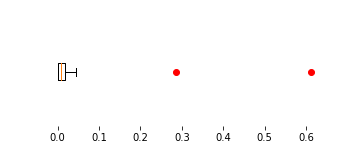
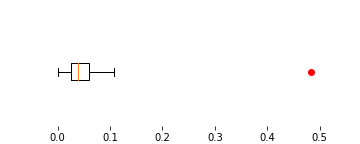
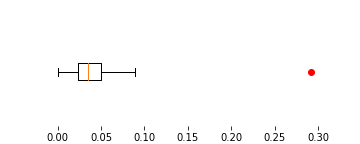
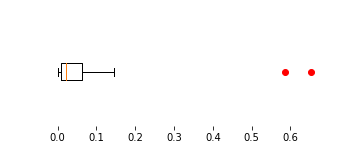
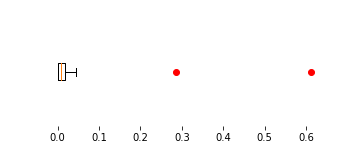
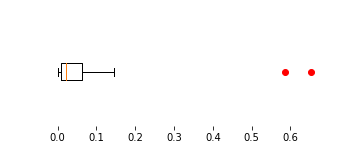
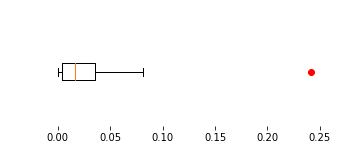
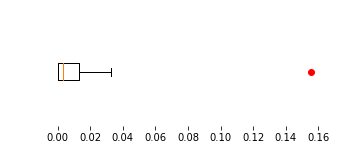
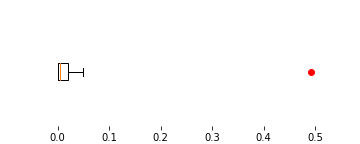
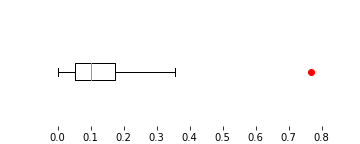

In [32]:
selected = combined.loc[((combined.pct=='99P')
                         &(combined.denom>200)
                         &(combined['mean_nat']>0.01)),['pct', 'num', 'denom', 'ratio',
                                                                  'stds_from_mean_nat','stds_from_mean_ccg',
                                                                  'chemical name', 'subpara name']].sort_values('stds_from_mean_nat',
                                                                   ascending=False).head(10)
make_table(selected, data2[['chemical','ratio']])
#table[['pct','num','denom','ratio','stds_from_mean_nat','stds_from_mean_ccg','plot','chemical name','subpara name']]

In [ ]:
data2#[['chemical','ratio']]